In [43]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [3]:
url = "https://raw.githubusercontent.com/pedroteche-ih/DAFT_MEX_202209/main/data/tb_ames_housing.csv"
tb_housing = pd.read_csv(url)
clu_vars = [
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal"
]
tb_housing = tb_housing.dropna(subset=clu_vars)

# Visualizando Estrutura de Correlação

Até agora vimos duas formas de tratar colinearidade: através da seleção manual de variáveis utilizando a matriz de correlação e utilizando PCA. Hoje veremos mais técnicas exploratórias para visualizar nosso espaço de features.

<Axes: >

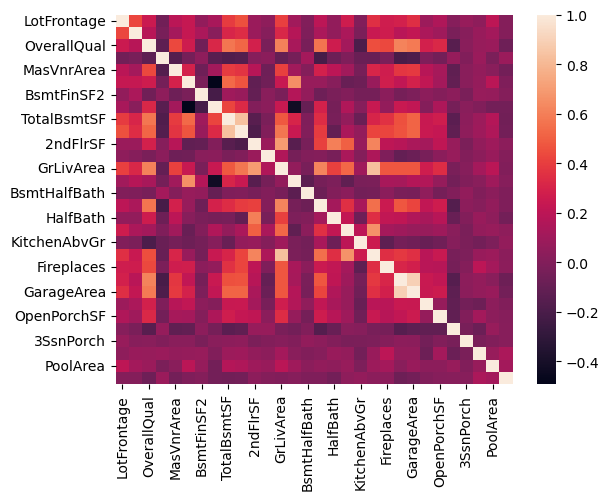

In [4]:
sns.heatmap(tb_housing[clu_vars].corr())

# Utilizando HACs

Como vimos na aula passada, HACs são ferramentas poderosas que nos permitem agrupar de forma hierarquica as observações de um dataset. HACs tem uma limitação: não escalam bem conforme **aumentamos o número de pontos em um dataset**.

Para utilizar um HAC para clusterizar nossas variáveis basta perceber que se **transpormos** nossa matriz de dados nossas *observações serão nossas variáveis!* Além de permitir clusterizar nossas variáveis, isto contorna a principal limitação dos HACs: mesmo que nosso dataset contenha centena de *features* não teremos problemas com limitações de memória e processamento.

In [5]:
scaler = StandardScaler()
tb_sca_housing_num = scaler.fit_transform(tb_housing[clu_vars])


In [6]:
tb_sca_housing_num.shape

(1195, 30)

Poddemos usar o atributo `.T` para acessar a matriz transposta:

In [7]:
tb_sca_housing_num.T.shape


(30, 1195)

Uma consideração importante a se fazer quando agrupamos variáveis utilizando um HAC é a definição da distância: embora a distância euclideana seja suficiente para maior parte dos problemas ela não é uma boa função de distância para medir semelhança entre variáveis.

Uma medida que já aprendemos nos permite estimar bem esta semelhança: a distância de correlação.

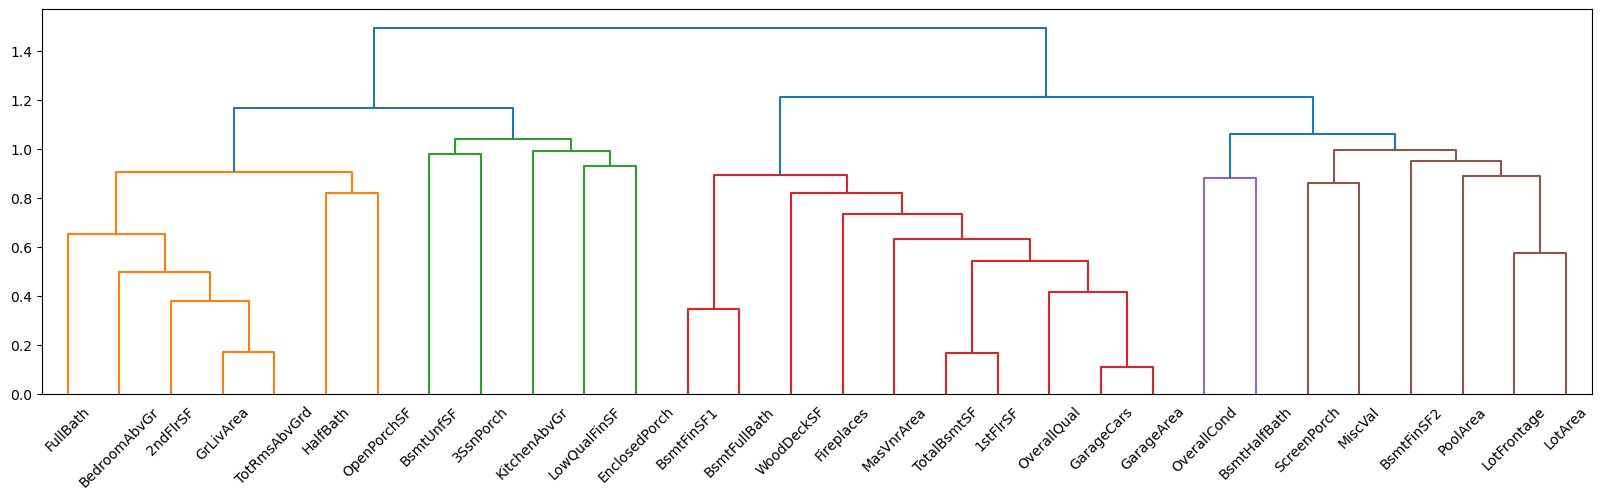

In [8]:
fig = plt.figure(figsize=(20, 5))
link = linkage(tb_sca_housing_num.T, method="complete", metric="cosine")
housing_dendogram = dendrogram(link, labels=scaler.feature_names_in_)


Vamos investigar a matriz de correlação do primeiro grupo de variáveis (à distância 0.8):

<Axes: >

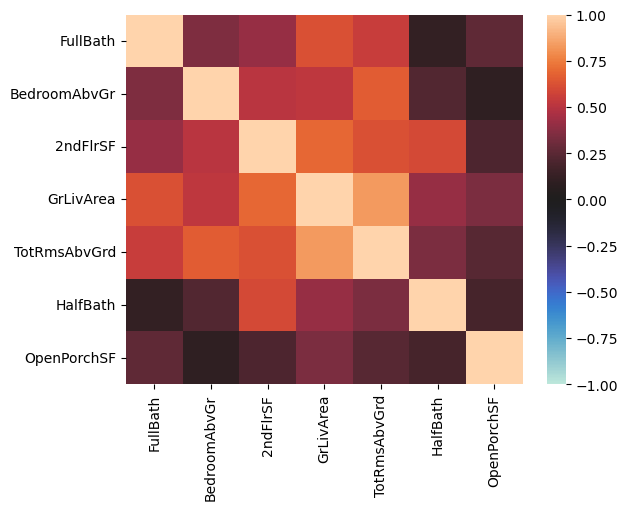

In [9]:
clu_0 = [
    "FullBath",
    "BedroomAbvGr",
    "2ndFlrSF",
    "GrLivArea",
    "TotRmsAbvGrd",
    "HalfBath",
    "OpenPorchSF",
]
sns.heatmap(tb_housing[clu_0].corr(), vmin=-1, center=0, vmax=1)


Esta técnica de agrupamento de features é muito utilizada como **ferramenta exploratória**, complementar a utilização da matriz de correlação. Mesmo assim, podemos utilizar a função `FeatureAgglomeration` para calcular uma transformação a partir dos agrupamentos estimados:

In [10]:
from sklearn.cluster import FeatureAgglomeration

In [11]:
n = 5
var_fit = FeatureAgglomeration(n_clusters=n, affinity='cosine', linkage='complete')
var_fit.fit(tb_sca_housing_num)


FeatureAgglomeration(affinity='cosine', linkage='complete', n_clusters=5)

In [12]:
tb_var_cluster = pd.DataFrame(
    var_fit.transform(tb_sca_housing_num), 
    columns=["CLU_" + str(i) for i in range(n)]
)
tb_var_cluster.head()

,CLU_0,CLU_1,CLU_2,CLU_3,CLU_4
0,-0.361984,-0.191716,0.063467,0.698823,-0.373469
1,-0.302244,-0.064602,0.315289,-0.296102,3.131200
2,-0.235371,-0.112334,0.214715,0.506722,-0.373469
3,0.692607,-0.202944,0.186889,-0.020641,-0.373469
4,-0.210405,0.060697,0.922624,1.209720,-0.373469


# Multi-Dimensional Scaling (MDS)

A primeira técnica não-supervisionada que aprendemos foi PCA - uma técnica que busca uma **projeção** de nossos dados em um espaço dimensional reduzido, eliminando colinearidades. Uma das limitações de PCA é que reduzimos apenas relações lineares: se duas variáveis tem uma relação não-linear, PCA não irá capturar este padrão.

Nesses casos podemos utilizar outra técnica exploratória: **MDS**. MDS (*multi-dimensional scaling*) é uma técnica semelhante à PCA mas que utiliza a proximidade entre observações para criar uma mapa de dimensionalidade reduzida. Podemos pensar nesta operação como a criação de um mapa mundi a partir de um globo: reduzimos as dimensões de nosso dataset enquanto tentamos manter as *similaridades locais* do espaço original.

## Utilizando MDS para Clusterização

In [13]:
from sklearn.manifold import MDS

In [14]:
url = 'https://raw.githubusercontent.com/pedroteche-ih/DAFT_MEX_202209/main/data/tb_household_electricity.csv'
tb_house = pd.read_csv(url, parse_dates = ['date_time'])
tb_house.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,date_time
0,2.268,0.000,235.94,9.6,0.0,0.0,17.0,2008-01-23 21:14:00
1,4.152,0.354,238.13,17.4,1.0,38.0,17.0,2008-02-02 16:42:00
2,1.448,0.212,240.99,6.0,0.0,2.0,18.0,2008-03-21 11:29:00
3,0.284,0.072,237.66,1.2,0.0,0.0,0.0,2008-02-28 10:13:00
4,0.452,0.084,239.81,1.8,0.0,0.0,0.0,2007-03-07 20:10:00


In [15]:
tb_house = tb_house.sample(1000, random_state=42).copy()
tb_house = tb_house.drop('date_time', axis = 1)
clu_vars_h = ['sub_metering_1', 'sub_metering_2', 'sub_metering_3']


In [16]:
scaler = StandardScaler()
scaler.fit(tb_house[clu_vars_h])
tb_sca_cp = pd.DataFrame(
    scaler.transform(tb_house[clu_vars_h]),
    columns = scaler.feature_names_in_
)

tb_sca_cp.head()

,sub_metering_1,sub_metering_2,sub_metering_3
0,-0.176843,-0.228821,-0.759886
1,-0.176843,-0.228821,1.398199
2,-0.176843,-0.228821,-0.759886
3,3.383750,-0.228821,1.278306
4,-0.176843,-0.228821,-0.759886


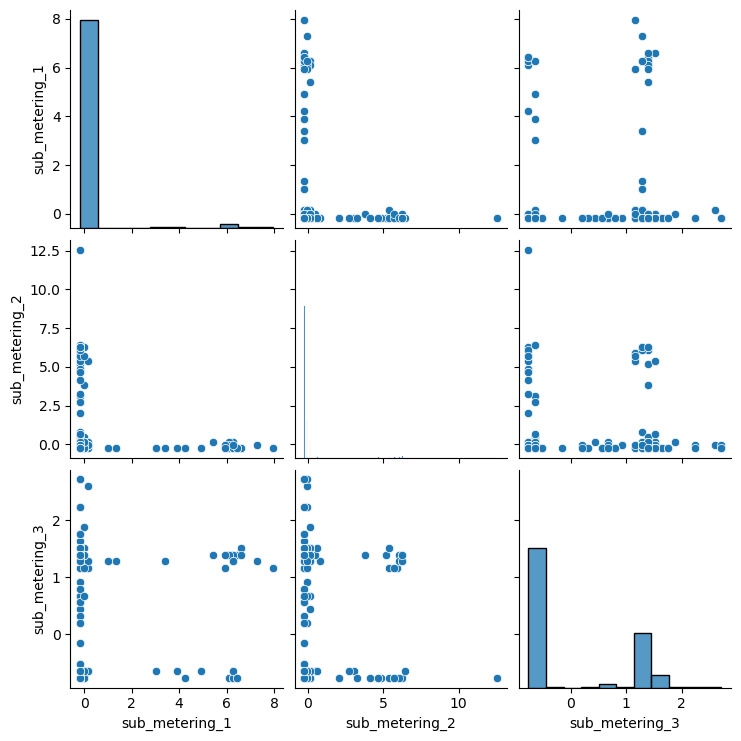

In [17]:
sns.pairplot(tb_sca_cp)

In [18]:
mds_fit = MDS(n_components=2, random_state = 42)
mds_array = mds_fit.fit_transform(tb_sca_cp)

tb_mca_house = pd.DataFrame(
    mds_array,
    columns = ['MC_0', 'MC_1']
)

<Axes: xlabel='MC_0', ylabel='MC_1'>

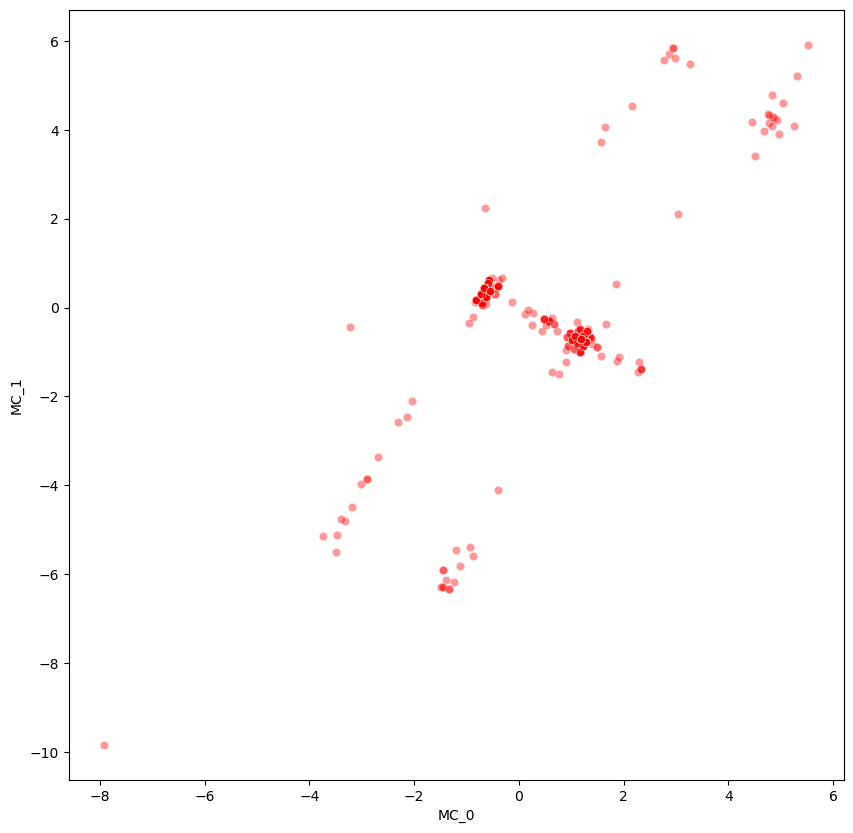

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
sns.scatterplot(data = tb_mca_house, x = 'MC_0', y = 'MC_1', color = 'red', alpha = 0.4)

<Axes: xlabel='MC_0', ylabel='MC_1'>

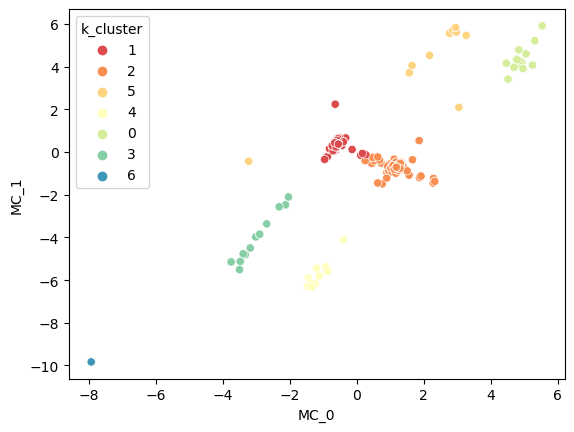

In [20]:
k_fit = KMeans(n_clusters = 7)
k_fit.fit(tb_sca_cp)
tb_mca_house['k_cluster'] = [str(x) for x in k_fit.labels_]
sns.scatterplot(data = tb_mca_house, x = 'MC_0', y = 'MC_1', hue = 'k_cluster', palette='Spectral')

In [21]:
tb_sca_cp['k_cluster'] = tb_mca_house['k_cluster']
tb_house_melt = tb_sca_cp.melt(id_vars = ['k_cluster'])

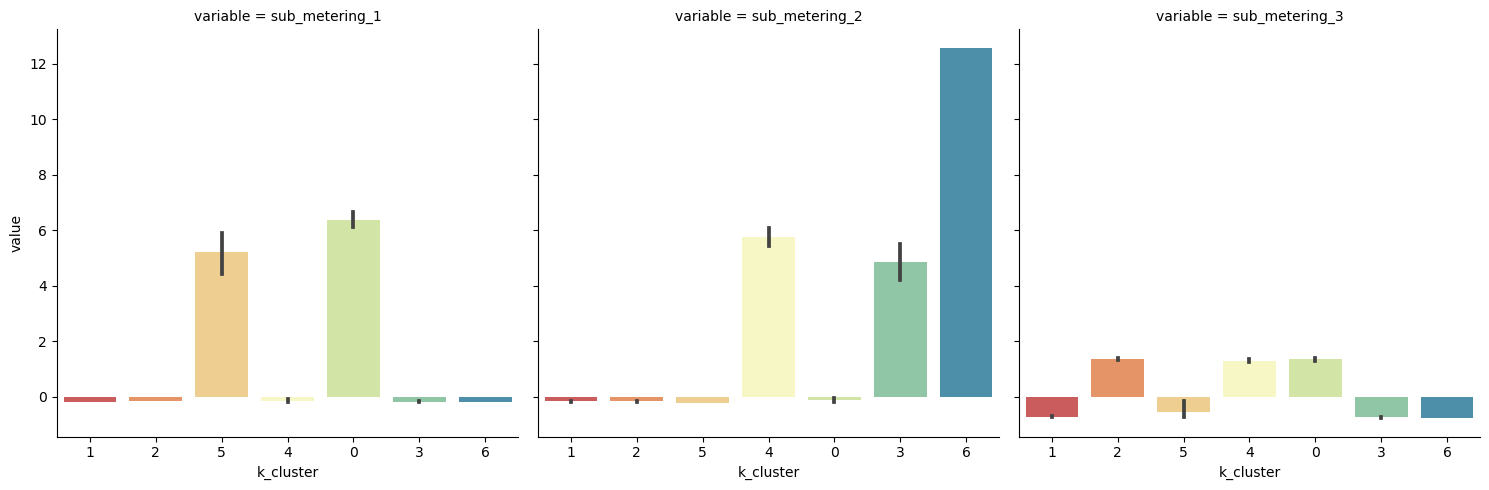

In [22]:
sns.catplot(data = tb_house_melt, x = 'k_cluster', y = 'value', col= 'variable', kind = 'bar', col_wrap = 3, palette = 'Spectral')

# UMAP

**UMAP** (*Uniform Manifold Approximation and Projection*) é uma técnica de redução de dimensionalidade utilizada para visualizar dados de alta dimensão em um espaço de dimensão inferior. Foi introduzida em 2018 por Leland McInnes, John Healy e James Melville.

O UMAP é particularmente eficaz em preservar tanto a **estrutura global** quanto **local** dos dados, tornando-se uma ferramenta poderosa para *análise exploratória de dados* e *visualização*. Ao contrário de métodos tradicionais, como **Análise de Componentes Principais (PCA)** ou **t-SNE (t-Distributed Stochastic Neighbor Embedding)**, o UMAP é baseado em uma estrutura matemática diferente chamada **geometria Riemanniana**.

O algoritmo por trás do UMAP envolve a construção de uma representação topológica difusa dos dados de alta dimensão, que captura as relações e similaridades entre os pontos de dados. Essa representação é então otimizada para encontrar uma *incorporação de baixa dimensão* que preserve a estrutura local e global dos dados originais.

Uma vantagem notável do UMAP é sua escalabilidade. Ele pode lidar com conjuntos de dados grandes, com milhões de pontos de dados e espaços de recursos de alta dimensão. Além disso, o UMAP permite *exploração interativa*, fornecendo atualizações em tempo real à medida que o usuário ajusta parâmetros ou interage com a visualização.

O UMAP tem ganhado popularidade em várias áreas, incluindo biologia, genômica, análise de imagens e processamento de linguagem natural. Ele tem se mostrado útil em tarefas como *análise de agrupamento*, *detecção de anomalias* e *extração de características*, permitindo que pesquisadores e cientistas de dados obtenham insights de dados complexos e de alta dimensão.

Em resumo, o UMAP oferece uma abordagem versátil e eficiente para redução de dimensionalidade, fornecendo uma ferramenta valiosa para visualizar e analisar conjuntos de dados complexos, ao mesmo tempo em que preserva informações estruturais importantes.

In [23]:
import umap

In [24]:
tb_revenda = pd.read_csv("data/tb_revenda.csv")
tb_revenda['categoria_produto'] = tb_revenda['categoria_produto'].astype(str).map(lambda cat: cat.lower())
tb_cliente_produto = pd.crosstab(
    tb_revenda["cd_cliente"],
    tb_revenda["categoria_produto"],
    values=tb_revenda["receita_bruta"],
    aggfunc="sum",
    normalize="index",
)
scaler = StandardScaler()
scaler.fit(tb_cliente_produto)
tb_sca_cp = pd.DataFrame(
    scaler.transform(tb_cliente_produto), columns=tb_cliente_produto.columns, index = tb_cliente_produto.index
)
tb_sca_cp.head()

categoria_produto,bateria,carregador,cooler,fonte,hdd,memoria,mouse,nan,placa,ssd,teclado,tela
cd_cliente,,,,,,,,,,,,
1,-0.065400,-0.028091,-0.283966,-0.089796,-0.060573,1.094673,-0.061734,-0.121387,-0.244826,1.920958,-0.377684,-0.988174
6,-0.829432,-0.028091,-0.294541,-0.417215,-0.060573,-0.228534,-0.061734,-0.121387,-0.244826,-0.441400,-0.547122,1.893138
14,-0.565341,-0.028091,-0.224830,-0.417215,-0.060573,-0.228534,-0.061734,-0.121387,-0.244826,-0.441400,0.600698,0.885458
32,-0.829432,-0.028091,-0.294541,-0.417215,-0.060573,-0.228534,-0.061734,-0.121387,-0.244826,-0.441400,-0.547122,1.893138
49,1.722181,-0.028091,-0.294541,-0.417215,-0.060573,-0.228534,-0.061734,-0.121387,-0.244826,-0.441400,-0.547122,-0.478434


In [33]:
umap_fit_5 = umap.UMAP(n_neighbors = 5, n_components=2, random_state=42)
umap_fit_5.fit(tb_sca_cp)

umap_fit_20 = umap.UMAP(n_neighbors = 20, n_components=2, random_state=42)
umap_fit_20.fit(tb_sca_cp)

umap_fit_50 = umap.UMAP(n_neighbors = 50, n_components=2, random_state=42)
umap_fit_50.fit(tb_sca_cp)

UMAP(n_neighbors=50, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [35]:
tb_umap_5 = pd.DataFrame(
    umap_fit_5.transform(tb_sca_cp),
    columns=["UM_0", "UM_1"],
    index = tb_sca_cp.index
)
tb_umap_20 = pd.DataFrame(
    umap_fit_20.transform(tb_sca_cp),
    columns=["UM_0", "UM_1"],
    index = tb_sca_cp.index
)

tb_umap_50 = pd.DataFrame(
    umap_fit_50.transform(tb_sca_cp),
    columns=["UM_0", "UM_1"],
    index = tb_sca_cp.index
)


Text(0.5, 1.0, 'UMAP with 50 Neighbors')

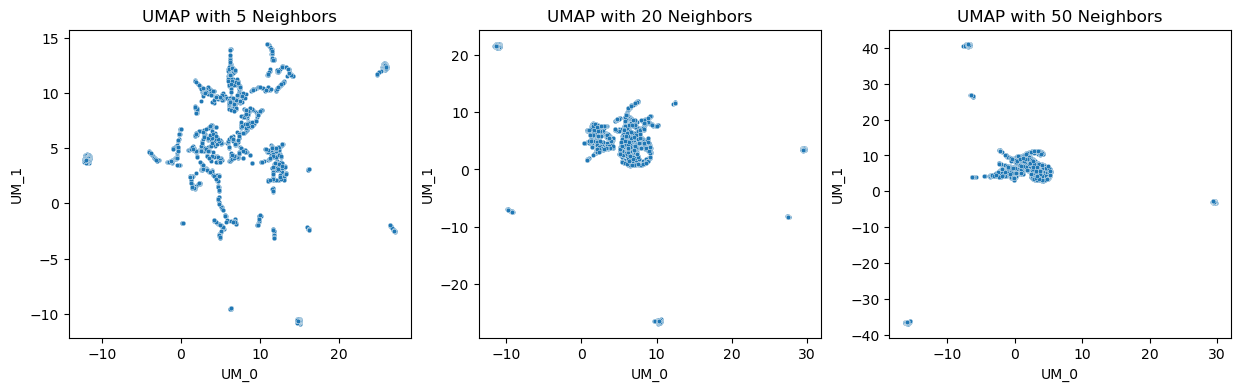

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.scatterplot(data=tb_umap_5, x="UM_0", y="UM_1", s = 10, ax = ax[0])
ax[0].set_title("UMAP with 5 Neighbors")
sns.scatterplot(data=tb_umap_20, x="UM_0", y="UM_1", s = 10, ax = ax[1])
ax[1].set_title("UMAP with 20 Neighbors")
sns.scatterplot(data=tb_umap_50, x="UM_0", y="UM_1", s = 10, ax = ax[2])
ax[2].set_title("UMAP with 50 Neighbors")

Os mapeamentos UMAP podem ser utilizados como pré-processamento tanto em modelos preditivos (para criar novos features) quanto como técnica de visualização. Sua utilização para clusterização é mais limitada, podemos utiliza-lá como ferramenta exploratória mas devemos tomar cuidado com qualquer clusterização que realizarmos sobre os componentes. Uma das principais razões para isso é que o UMAP não preserva a **densidade** no espaço de features. Podemos utilizar o argumento `densmap = True` para contornar parcialmente esse problema, mas ainda assim, sempre que possível, devemos utilizar o UMAP como ferramenta exploratória em problemas não supervisionados:

Text(0.5, 1.0, 'UMAP with 50 Neighbors')

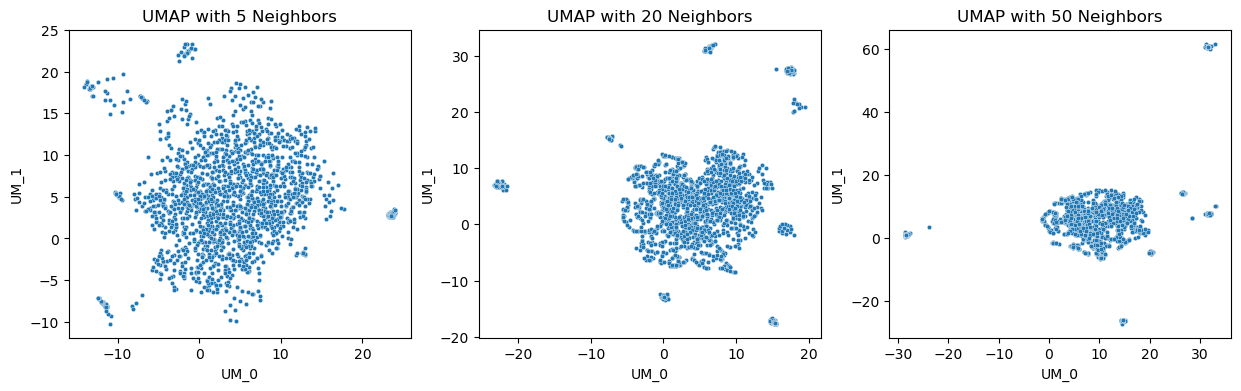

In [92]:
umap_fit_5 = umap.UMAP(n_neighbors = 5, n_components=2, random_state=42, densmap = True)
umap_fit_5.fit(tb_sca_cp)

umap_fit_20 = umap.UMAP(n_neighbors = 20, n_components=2, random_state=42, densmap = True)
umap_fit_20.fit(tb_sca_cp)

umap_fit_50 = umap.UMAP(n_neighbors = 50, n_components=2, random_state=42, densmap = True)
umap_fit_50.fit(tb_sca_cp)

tb_umap_5 = pd.DataFrame(
    umap_fit_5.transform(tb_sca_cp),
    columns=["UM_0", "UM_1"],
    index = tb_sca_cp.index
)
tb_umap_20 = pd.DataFrame(
    umap_fit_20.transform(tb_sca_cp),
    columns=["UM_0", "UM_1"],
    index = tb_sca_cp.index
)

tb_umap_50 = pd.DataFrame(
    umap_fit_50.transform(tb_sca_cp),
    columns=["UM_0", "UM_1"],
    index = tb_sca_cp.index
)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.scatterplot(data=tb_umap_5, x="UM_0", y="UM_1", s = 10, ax = ax[0])
ax[0].set_title("DENSMAP with 5 Neighbors")
sns.scatterplot(data=tb_umap_20, x="UM_0", y="UM_1", s = 10, ax = ax[1])
ax[1].set_title("DENSMAP with 20 Neighbors")
sns.scatterplot(data=tb_umap_50, x="UM_0", y="UM_1", s = 10, ax = ax[2])
ax[2].set_title("DENSMAP with 50 Neighbors")